In [23]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

import cpn_model
import config
import michaels_load
import mRNN
import stim_model
import utils 


OBSERVER_TYPE = "gaussian"
STIMULATION_TYPE = "gaussianExp"
CPN_ACTIVATION_TYPE = "Tanh"
EN_ACTIVATION_TYPE = "Tanh"
LESION_TYPE = "connection"
OBS_OUT_DIM = 20
#NUM_STIM_CHANNELS = 32
#STIM_SIGMA = 0.875
NUM_STIM_CHANNELS = 64
STIM_SIGMA = 0.875

# Got there in 12k
#NUM_STIM_CHANNELS = 20
#STIM_SIGMA = 1.875

BATCH_SIZE = 128

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, recovery_mode, recovery_str, \
        run_type_str, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              stim_retain_grad=True,
                                              obs_out_dim=OBS_OUT_DIM)


CPN_DATA_DIR = "cpn"
EN_DATA_DIR = "en"
MRNN_DIR = "mrnn"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)



In [25]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path())

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_cpn = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Loader produces lists of len 2:
#  (input of batch, output of batch); which is:
#  (shape(<=batch_size, time, 21), shape(<=batch_size, time, 50))

torch.Size([341, 21])
torch.Size([1, 341, 50])
torch.Size([1, 341, 50])


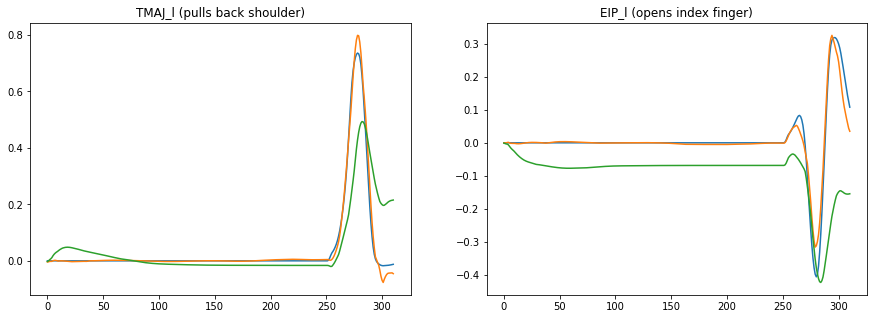

In [26]:
# Just some choice of examples, for graphical comparison
example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


print(example_din.shape)
print(reference_pred_healthy.shape)
print(reference_pred_lesioned.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(example_dout[:trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_healthy[0, :trial_len, 7].detach().numpy())
ax[0].plot(reference_pred_lesioned[0, :trial_len, 7].detach().numpy())
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(example_dout[:trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_healthy[0, :trial_len, 45].detach().numpy())
ax[1].plot(reference_pred_lesioned[0, :trial_len, 45].detach().numpy())

plt.show()

tensor(0.0006, grad_fn=<MseLossBackward>)
tensor(0.0207, grad_fn=<MseLossBackward>)


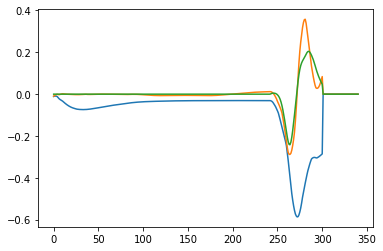

In [27]:
# Now a numerical comparison
comp_loss = torch.nn.MSELoss()

loader_comp = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)
for s in loader_comp:
    din, trial_end, _, dout = s

comp_preds_healthy = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
mike.set_lesion(None)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_healthy[:, tidx, :] = p[:, :]
comp_preds_healthy = utils.trunc_to_trial_end(comp_preds_healthy, trial_end)
comp_loss_healthy = comp_loss(comp_preds_healthy, dout)
print(comp_loss_healthy)

comp_preds_lesioned = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_lesioned[:, tidx, :] = p[:, :]
comp_preds_lesioned = utils.trunc_to_trial_end(comp_preds_lesioned, trial_end)
comp_loss_lesioned = comp_loss(comp_preds_lesioned, dout)
print(comp_loss_lesioned)


plt.plot(comp_preds_lesioned[0, :, 20].detach().numpy())
plt.plot(comp_preds_healthy[0, :, 20].detach().numpy())
plt.plot(dout[0, :, 20].detach().numpy())
plt.show()


In [28]:
def unroll(cpn, mike, din, trial_end, observer,
           drop_module_idx=None, retain_stim_grads=False):
    batch_size = din.shape[0]
    steps = din.shape[1]
    obs_dim = 3 * observer.out_dim
    
    stims = []
    actuals = torch.zeros(batch_size, steps - 1, mike.output_dim)
    
    # This is the actual, which EN predicts
    mike_out = mike(din[:, 0, :].T)
    
    for tidx in range(steps - 1):
        obs = mike.observe(observer, drop_module_idx=drop_module_idx)
        new_obs_cpn = torch.cat(tuple([torch.tensor(o).float() for o in obs]),
                            axis=1)

        # cpn recieves (obs, trial_end)
        cpn_in = torch.cat((new_obs_cpn, trial_end[:, tidx, :]), axis=1)
        # output is (batch_size, num_stim_channels)
        new_stim = cpn(cpn_in)
        assert new_stim.shape == (batch_size, mike.stimulus.num_stim_channels)
        if retain_stim_grads:
            new_stim.retain_grad()
        stims.append(new_stim)
            
        # new_stim will be cloned in here, to prevent accidentally backprop-ing
        # through the "brain", aka mike.
        mike.stimulate(new_stim)
                
        # Note that 'preds' lags 'actual' by a time step, hence
        # 'pred' is a prediction of the actual en activity
        mike_out = mike(din[:, tidx + 1, :].T)
        actuals[:, tidx, :] = mike_out[:, :]
        
    actuals = utils.trunc_to_trial_end(actuals, trial_end[:, :-1, :])
    return actuals, stims 

In [ ]:
obs_dim = observer.out_dim * 3
# +1 for trial_end
cpn_in_dim = obs_dim + 1
cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
                             num_neurons=cpn_in_dim, activation_func=torch.nn.Tanh)


opt_cpn = AdamW(cpn.parameters(), lr=5e-6)

# Just for zero grad purposes
opt_mrnn = AdamW(mike.parameters())

loss = torch.nn.MSELoss()
rli = 1

real_losses = []
super_epoch_count = 0

eidx = -1
while True:       
    super_epoch_count += 1
    
    recent_losses = []
    num_regressed = 0
    while True:
        for batch in loader_cpn:
            eidx += 1
            opt_cpn.zero_grad()
            opt_mrnn.zero_grad()
            cpn.reset()
            mike.reset()
            
            if rli > 0.02:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-4
            elif rli <= 0.015:
                for p in opt_cpn.param_groups:
                    #p['lr'] = 1e-5
                    p['lr'] = 1e-4
            elif rli <= 0.0125:
                for p in opt_cpn.param_groups:
                    p['lr'] = 5e-6
            elif rli <= 0.01:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-7
            elif rli <= 0.001:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-8
            
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
    
            actuals, stims = unroll(cpn, mike, din, trial_end, observer,
                                           retain_stim_grads=True)
            
            rl = loss(actuals, dout[:, 1:, :])
            rli = rl.item()
            rl.backward()  
            
            print("cpn", eidx, rl.item())
            real_losses.append(rli)
            
            torch.save(cpn.state_dict(), "latest_cpn_F5condrop_obs20_stim92_nn150_noen")
            if rli == min(real_losses) and rli < 0.01:
                torch.save(cpn.state_dict(), "min_cpn_F5condrop_obs20_stim92_nn150_noen")
                                                          
            bail = False
            done = False
            # Done
            if rli < 5e-5:
                bail = True
                done = True
                break
                
            opt_cpn.step()
                
            if bail:
                break
                
        if bail:
            break
            
    if done:
        break

cpn 0 0.03352460637688637
cpn 1 0.03358183428645134
cpn 2 0.03181133046746254
cpn 3 0.030951550230383873
cpn 4 0.030079364776611328
cpn 5 0.029302645474672318
cpn 6 0.028942495584487915
cpn 7 0.028405843302607536
cpn 8 0.027987897396087646
cpn 9 0.02666698954999447
cpn 10 0.025511419400572777
cpn 11 0.024975934997200966
cpn 12 0.024452928453683853
cpn 13 0.023711519315838814
cpn 14 0.023791110143065453
cpn 15 0.02307077683508396
cpn 16 0.022198980674147606
cpn 17 0.02160901390016079
cpn 18 0.020970219746232033
cpn 19 0.021378492936491966
cpn 20 0.020870639011263847
cpn 21 0.01963222771883011
cpn 22 0.01902836747467518
cpn 23 0.018568186089396477
cpn 24 0.018314875662326813
cpn 25 0.018063729628920555
cpn 26 0.01741691865026951
cpn 27 0.016782177612185478
cpn 28 0.01667274348437786
cpn 29 0.015826381742954254
cpn 30 0.015975452959537506
cpn 31 0.015077561140060425
cpn 32 0.014548812061548233
cpn 33 0.01451055333018303
cpn 34 0.014200306497514248
cpn 35 0.014015168882906437
cpn 36 0.0133

cpn 286 0.0034705204889178276
cpn 287 0.003461276413872838
cpn 288 0.003417658619582653
cpn 289 0.0034618235658854246
cpn 290 0.0033297576010227203
cpn 291 0.003354147542268038
cpn 292 0.0032464296091347933
cpn 293 0.0034312226343899965
cpn 294 0.003403885057196021
cpn 295 0.003397677093744278
cpn 296 0.0033731460571289062
cpn 297 0.0033403856214135885
cpn 298 0.0033443961292505264
cpn 299 0.00332103343680501
cpn 300 0.0033174268901348114
cpn 301 0.0032734940759837627
cpn 302 0.0033265019301325083
cpn 303 0.003376093227416277
cpn 304 0.003137533785775304
cpn 305 0.0033429001923650503
cpn 306 0.00337857473641634
cpn 307 0.0033632139675319195
cpn 308 0.0034252414479851723
cpn 309 0.003237765049561858
cpn 310 0.0032181639689952135
cpn 311 0.0032285312190651894
cpn 312 0.003138341009616852
cpn 313 0.003248226596042514
cpn 314 0.003231961978599429
cpn 315 0.003415243001654744
cpn 316 0.003209464019164443
cpn 317 0.0033341641537845135
cpn 318 0.003179619088768959
cpn 319 0.003208945505321026

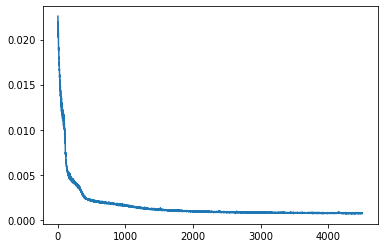

0.000674609502311796
0.9946036951070787 tensor(0.0207, grad_fn=<MseLossBackward>) tensor(0.0006, grad_fn=<MseLossBackward>)


In [11]:
plt.plot(real_losses)
plt.show()
print(min(real_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

In [26]:
# TODO: get a CPN collection and explore the impact of the level of noise we are using.
# TODO: look for classes or data points we suck at
# TODO: train vs test
# TODO: deep dive EN grads bad

print(recent_losses)

[0.012536630965769291, 0.012541639618575573]


torch.Size([1, 341, 50])


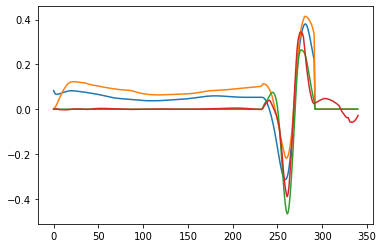

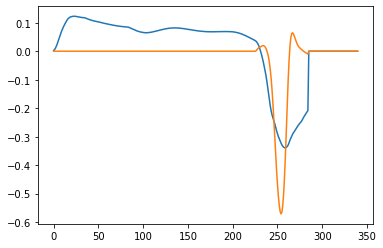

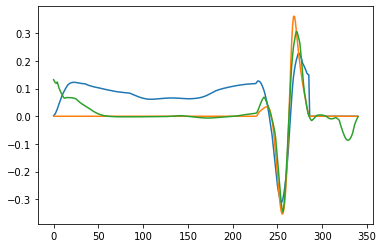

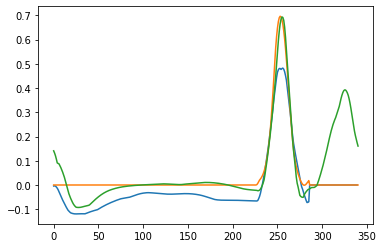

In [27]:
mike.reset()
reference_pred_lesioned_0 = mike.unroll(din[0, :, :].T)
reference_pred_lesioned_neg1 = mike.unroll(din[-1, :, :].T)
reference_pred_lesioned_20 = mike.unroll(din[20, :, :].T)
mike.reset()

print(reference_pred_lesioned_0.shape)


plt.plot(preds[0, :, 45].detach().numpy())
#plt.plot(preds.grad[0, :, 45].detach().numpy())
plt.plot(actuals[0, :, 45].detach().numpy())
plt.plot(dout[0, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_0[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[-1, :, 45].detach().numpy())
plt.plot(actuals[-1, :, 45].detach().numpy())
plt.plot(dout[-1, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 45].detach().numpy())
plt.plot(actuals[20, :, 45].detach().numpy())
plt.plot(dout[20, :, 45].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 45].detach().numpy())
plt.show()

#plt.plot(preds[20, :, 7].detach().numpy())
plt.plot(actuals[20, :, 7].detach().numpy())
plt.plot(dout[20, :, 7].detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 7].detach().numpy())
plt.show()

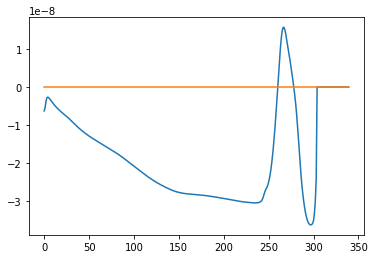

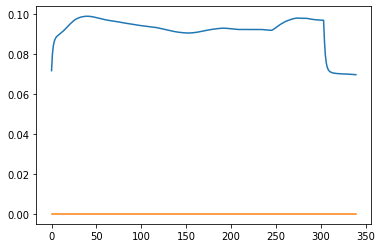

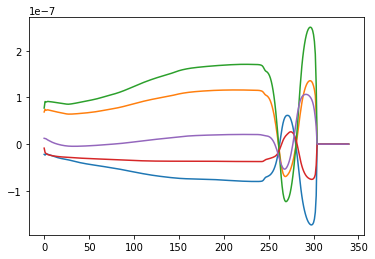

In [44]:
ss = [x[20, 6].item() for x in stims]
gg = [x.grad[20, 6].item() for x in stims]
ref = [0.0 for x in stims]

plt.plot(gg)
plt.plot(ref)
plt.show()
plt.plot(ss)
plt.plot(ref)
plt.show()

for idx in range(0, 25, 5):
    gg = [x.grad[20, idx].item() for x in stims]
    plt.plot(gg)
plt.show()

# On bad run: gradient is negative when values are too high

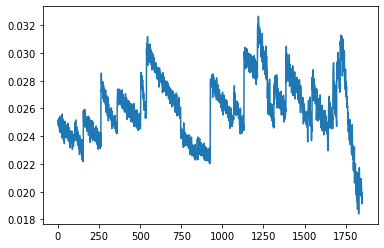

In [12]:
plt.plot(cpn_losses)